In [5]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from typing import List, Dict, Optional
import warnings

Order Flow Imbalance analyzer 

Steps:-

1. Parameters:
    
    1.1 data : Order book data containing bid/ask prices and sizes
    
    1.2 levels : Number of order book levels to consider (default: 10)
    
    1.3 time_window : Time window for aggregating OFI (default: '1min')

2. Validate the input data structure.
3. Pre-process the order book data for OFI calculations.
4. Calculate OFI for a single level using vectorized operations.
5. Calculate Best-Level OFI (level 0) and aggregate by time window.
6. Calculate Multi-Level OFI by aggregating across all levels.
7. Calculate Integrated OFI using PCA on multi-level OFI.
8. Calculate Cross-Asset OFI using LASSO regression.
9. Calculate all OFI features and combine into a single DataFrame.


In [ ]:
class OFIAnalyzer:
    
    def __init__(self, data: pd.DataFrame, levels: int = 10, time_window: str = '1min'):
        # Validate input data
        required_columns = ['ts_event', 'symbol', 'bid_px_00', 'ask_px_00']
        if not all(col in data.columns for col in required_columns):
            raise ValueError(f"Input data must contain these columns: {required_columns}")
            
        self.data = data.copy()
        self.levels = min(levels, 10)  # Ensure we don't exceed available levels
        self.time_window = time_window
        self.symbols = data['symbol'].unique()
        self._validate_data()
        self._preprocess_data()
        
    def _validate_data(self) -> None:
        # Check that all required level columns exist
        for level in range(self.levels):
            for prefix in ['bid_px_', 'ask_px_', 'bid_sz_', 'ask_sz_']:
                col = f"{prefix}{level:02d}"
                if col not in self.data.columns:
                    raise ValueError(f"Missing required column: {col}")
    
    def _preprocess_data(self) -> None:
        # Convert timestamps and sort
        self.data['ts_event'] = pd.to_datetime(self.data['ts_event'])
        self.data['ts_recv'] = pd.to_datetime(self.data['ts_recv'])
        self.data = self.data.sort_values('ts_event')
        
        # Calculate mid-price and create time bins
        self.data['mid_price'] = (self.data['bid_px_00'] + self.data['ask_px_00']) / 2
        self.data['time_bin'] = self.data['ts_event'].dt.floor(self.time_window)
        
    def _calculate_single_level_ofi(self, level: int) -> pd.Series:
        # Get column names for this level
        bid_px_col = f'bid_px_{level:02d}'
        ask_px_col = f'ask_px_{level:02d}'
        bid_sz_col = f'bid_sz_{level:02d}'
        ask_sz_col = f'ask_sz_{level:02d}'
        
        # Group by symbol to handle each asset separately
        grouped = self.data.groupby('symbol')
        
        # Calculate price and size changes using vectorized operations
        bid_px_change = grouped[bid_px_col].diff()
        ask_px_change = grouped[ask_px_col].diff()
        bid_sz_change = grouped[bid_sz_col].diff()
        ask_sz_change = grouped[ask_sz_col].diff()
        
        # Calculate bid OFI component
        bid_ofi = (
            (bid_px_change > 0) * self.data[bid_sz_col] - 
            (bid_px_change < 0) * self.data[bid_sz_col] + 
            (bid_px_change == 0) * bid_sz_change.fillna(0)
        )
        
        # Calculate ask OFI component
        ask_ofi = (
            (ask_px_change > 0) * (-self.data[ask_sz_col]) - 
            (ask_px_change < 0) * self.data[ask_sz_col] + 
            (ask_px_change == 0) * ask_sz_change.fillna(0)
        )
        
        return bid_ofi + ask_ofi
    
    def calculate_best_level_ofi(self) -> pd.DataFrame:
        self.data['best_level_ofi'] = self._calculate_single_level_ofi(0)
        
        # Aggregate using sum (as per Cont et al.)
        result = (self.data.groupby(['time_bin', 'symbol'])['best_level_ofi']
                 .sum()
                 .unstack(fill_value=0)
                 .reset_index()
                 .rename(columns={'time_bin': 'timestamp'}))
        
        # For single asset, keep consistent column naming
        if len(self.symbols) == 1:
            result = result.rename(columns={self.symbols[0]: 'OFI_best'})
        
        return result
    
    def calculate_multi_level_ofi(self) -> pd.DataFrame:
        # Calculate OFI for each level and aggregate
        ofi_values = np.zeros(len(self.data))
        
        for level in range(self.levels):
            ofi_values += self._calculate_single_level_ofi(level)
        
        self.data['multi_level_ofi'] = ofi_values
        
        # Calculate average depth for scaling
        depth_values = np.zeros(len(self.data))
        for level in range(self.levels):
            bid_col = f'bid_sz_{level:02d}'
            ask_col = f'ask_sz_{level:02d}'
            depth_values += (self.data[bid_col] + self.data[ask_col]) / 2
        
        avg_depth = depth_values / self.levels
        self.data['multi_level_ofi'] = self.data['multi_level_ofi'] / avg_depth.replace(0, 1)
        
        # Aggregate results
        result = (self.data.groupby(['time_bin', 'symbol'])['multi_level_ofi']
                 .sum()
                 .unstack(fill_value=0)
                 .reset_index()
                 .rename(columns={'time_bin': 'timestamp'}))
        
        # Sum across levels and rename columns
        result['OFI_multi'] = result[self.symbols].sum(axis=1) if len(self.symbols) > 1 else result[self.symbols[0]]
        
        return result[['timestamp', 'OFI_multi'] + list(self.symbols)]
    
    def calculate_integrated_ofi(self) -> pd.DataFrame:
        # First calculate multi-level OFI for each level
        ofi_matrix = []
        for level in range(self.levels):
            ofi_matrix.append(self._calculate_single_level_ofi(level))
        
        ofi_matrix = pd.concat(ofi_matrix, axis=1)
        ofi_matrix.columns = [f'ofi_{level}' for level in range(self.levels)]
        
        # Standardize and apply PCA
        scaler = StandardScaler()
        pca = PCA(n_components=1)
        
        # Group by time bin and symbol
        grouped = pd.concat([self.data[['time_bin', 'symbol']], ofi_matrix], axis=1)
        grouped = grouped.groupby(['time_bin', 'symbol']).sum()
        
        # Apply PCA to each symbol's data
        results = []
        for symbol in self.symbols:
            symbol_data = grouped.xs(symbol, level='symbol')
            if len(symbol_data) < 2:
                warnings.warn(f"Not enough data points for PCA for symbol {symbol}")
                continue
                
            ofi_scaled = scaler.fit_transform(symbol_data)
            integrated_ofi = pca.fit_transform(ofi_scaled)
            
            # Normalize by L1 norm of weights
            weights = pca.components_[0]
            l1_norm = np.sum(np.abs(weights))
            integrated_ofi = integrated_ofi / l1_norm
            
            result = pd.DataFrame({
                'timestamp': symbol_data.index,
                'symbol': symbol,
                'OFI_integrated': integrated_ofi.flatten()
            })
            results.append(result)
        
        if not results:
            return pd.DataFrame(columns=['timestamp', 'OFI_integrated'])
            
        return pd.concat(results).reset_index(drop=True)
    
    def calculate_cross_asset_ofi(self, alpha: float = 0.1) -> pd.DataFrame:
        if len(self.symbols) < 2:
            warnings.warn("Insufficient assets for cross-asset OFI calculation")
            result = self.calculate_best_level_ofi()[['timestamp']].copy()
            result['OFI_cross'] = np.nan
            return result
        
        # Calculate best-level OFI for each asset
        asset_ofis = []
        for symbol in self.symbols:
            symbol_data = self.data[self.data['symbol'] == symbol].copy()
            symbol_data['ofi'] = self._calculate_single_level_ofi(0)
            
            ofi_ts = symbol_data.groupby('time_bin')['ofi'].sum().reset_index()
            ofi_ts = ofi_ts.rename(columns={'ofi': symbol})
            asset_ofis.append(ofi_ts)
        
        # Merge all assets' OFI
        ofi_matrix = asset_ofis[0]
        for df in asset_ofis[1:]:
            ofi_matrix = ofi_matrix.merge(df, on='time_bin', how='outer')
        ofi_matrix = ofi_matrix.fillna(0).sort_values('time_bin')
        
        # Calculate cross-impact using LASSO
        cross_results = []
        for target in self.symbols:
            X = ofi_matrix.drop(columns=['time_bin', target])
            y = ofi_matrix[target]
            
            if len(X) < 10:  # Minimum samples for meaningful regression
                cross_impact = np.zeros(len(X))
            else:
                lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
                lasso.fit(X, y)
                cross_impact = X @ lasso.coef_
            
            cross_results.append(pd.DataFrame({
                'timestamp': ofi_matrix['time_bin'],
                'symbol': target,
                'cross_ofi': cross_impact
            }))
        
        # Combine results
        cross_ofi = pd.concat(cross_results)
        cross_ofi = cross_ofi.groupby('timestamp')['cross_ofi'].mean().reset_index()
        cross_ofi = cross_ofi.rename(columns={'cross_ofi': 'OFI_cross'})
        
        return cross_ofi
    
    def calculate_all_features(self) -> pd.DataFrame:
        features = [
            self.calculate_best_level_ofi(),
            self.calculate_multi_level_ofi()[['timestamp', 'OFI_multi']],
            self.calculate_integrated_ofi(),
            self.calculate_cross_asset_ofi()
        ]
        
        # Merge all features
        result = features[0]
        for df in features[1:]:
            if not df.empty:
                result = result.merge(df, on='timestamp', how='left')
        
        for col in result.columns:
            if col not in ['timestamp', 'symbol', 'OFI_cross']:
                result[col] = result[col].fillna(0)
        
        return result





In [ ]:
def main():
    try:
        # Load and process data
        data = pd.read_csv('first_25000_rows.csv')
        analyzer = OFIAnalyzer(data, time_window='1min')
        
        # Calculate features
        features = analyzer.calculate_all_features()
        
        # Save and display results
        features.to_csv('enhanced_ofi_features-task-1.csv', index=False)
        print("Enhanced OFI features calculated and saved to enhanced_ofi_features.csv")
        print("\nSample results:")
        
        pd.set_option('display.max_rows', None)         
        pd.set_option('display.max_columns', None)      
        pd.set_option('display.width', 150)              
        pd.set_option('display.colheader_justify', 'center')
        pd.set_option('display.float_format', lambda x: f'{x:,.3f}')  

        print(features.to_string(index=False))
        # print(features)
        
        return features
        
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

In [12]:
if __name__ == '__main__':
    main()

Enhanced OFI features calculated and saved to enhanced_ofi_features.csv

Sample results:
        timestamp           OFI_best   OFI_multi symbol  OFI_integrated  OFI_cross
2024-10-21 11:54:00+00:00    -533.000   -34.961   AAPL       -0.640        NaN    
2024-10-21 11:55:00+00:00  -1,621.000   -84.327   AAPL       -0.494        NaN    
2024-10-21 11:56:00+00:00    -468.000   -67.502   AAPL       -0.508        NaN    
2024-10-21 11:57:00+00:00    -482.000  -133.391   AAPL       -0.344        NaN    
2024-10-21 11:58:00+00:00    -224.000  -223.096   AAPL       -0.065        NaN    
2024-10-21 11:59:00+00:00      72.000  -170.962   AAPL       -0.240        NaN    
2024-10-21 12:00:00+00:00     320.000  -148.917   AAPL       -0.265        NaN    
2024-10-21 12:01:00+00:00    -400.000   -84.695   AAPL       -0.385        NaN    
2024-10-21 12:02:00+00:00    -800.000  -140.118   AAPL       -0.145        NaN    
2024-10-21 12:03:00+00:00    -349.000   -79.075   AAPL       -0.403        NaN   

/var/folders/mc/l4_t7brd2v3cy_nrw6jzyjf40000gn/T/ipykernel_47403/2174729248.py:207: UserWarning: Insufficient assets for cross-asset OFI calculation
  warnings.warn("Insufficient assets for cross-asset OFI calculation")


# Insights

1. OFI cross is NAN as only AAPL stock details is given in the data

2. Best-Level OFI (Immediate Liquidity Impact)

        Extreme Selling: Peaks at -10,173 (12:15) and -8,795 (12:34) show intense liquidation

        Buying Spikes: Positive values at 11:59 (+72), 12:00 (+320), and 12:08 (+79) indicate brief aggressive buying

        Persistent Negativity: 85% of timestamps show negative OFI_best, confirming sustained selling pressure


3. Multi-Level OFI (Depth-Adjusted Pressure)

        Deep Book Activity: Largest imbalance at -906 (13:02) suggests orders walking deep into the book
    
        Ratio Analysis: When OFI_multi > 5× OFI_best (e.g., 12:15), indicates hidden liquidity absorption

4. Critical Time Periods

        12:15 Event

    OFI_best: -10,173 (maximum selling)
    
    OFI_multi: -530 (relatively moderate)
    
    OFI_integrated: +3.36 (strongest positive)
    
    Interpretation:
    
    Aggressive top-level liquidation while deeper levels showed buying interest -
    
    potentially stop-loss cascades hitting the top of book.
    
        13:02-13:03 Cluster

    Sustained deep selling (-906 to -650 multi-level)
    
    Integrated OFI remains positive
    
    Interpretation: Algorithmic selling program executing across multiple price levels.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

ofi_data = pd.read_csv('enhanced_ofi_features-task-1.csv', parse_dates=['timestamp'])

# Set style
plt.style.use('seaborn')
sns.set_palette("deep")

# 1. Fixed Triple-Panel Chart
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 1, figure=fig)

# Top panel: OFI_best (bar chart)
ax1 = fig.add_subplot(gs[0])
ofi_data.set_index('timestamp')['OFI_best'].plot(kind='bar', ax=ax1, width=0.8, color='royalblue')
ax1.set_title('Best-Level OFI (Immediate Liquidity Impact)', fontsize=12)
ax1.set_ylabel('OFI Value')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Middle panel: OFI_multi (line)
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ofi_data.set_index('timestamp')['OFI_multi'].plot(ax=ax2, color='darkorange', linewidth=2)
ax2.set_title('Multi-Level OFI (Depth-Adjusted Pressure)', fontsize=12)
ax2.set_ylabel('OFI Value')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# Bottom panel: OFI_integrated (fixed - using line plot instead of area)
ax3 = fig.add_subplot(gs[2], sharex=ax1)
# Create separate positive and negative series for proper area visualization
pos = ofi_data.set_index('timestamp')['OFI_integrated'].copy()
neg = pos.copy()
pos[pos < 0] = 0
neg[neg > 0] = 0

ax3.fill_between(pos.index, pos, color='forestgreen', alpha=0.5, label='Positive OFI')
ax3.fill_between(neg.index, neg, color='crimson', alpha=0.5, label='Negative OFI')
ax3.set_title('Integrated OFI (Dominant Order Flow Pattern)', fontsize=12)
ax3.set_ylabel('OFI Value')
ax3.axhline(0, color='black', linestyle='-', linewidth=0.5)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.legend()

plt.tight_layout()
plt.savefig('fixed_triple_panel_ofi.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Scatter Matrix (unchanged, works fine)
ofi_data['ofi_sign'] = ofi_data['OFI_integrated'].apply(lambda x: 'Positive' if x >= 0 else 'Negative')

plt.figure(figsize=(10, 8))
sns.scatterplot(data=ofi_data, x='OFI_best', y='OFI_multi', hue='ofi_sign', 
                palette={'Positive': 'limegreen', 'Negative': 'crimson'}, 
                size='OFI_integrated', sizes=(20, 200), alpha=0.7)
plt.title('OFI_best vs OFI_multi Colored by OFI_integrated Sign', fontsize=14)
plt.xlabel('Best-Level OFI')
plt.ylabel('Multi-Level OFI')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.grid(alpha=0.3)
plt.legend(title='OFI_integrated Sign')
plt.savefig('scatter_matrix_ofi.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Cumulative Sum (unchanged, works fine)
rolling_window = 5  # 5-minute window
for col in ['OFI_best', 'OFI_multi', 'OFI_integrated']:
    ofi_data[f'{col}_rolling'] = ofi_data[col].rolling(rolling_window).sum()

plt.figure(figsize=(14, 8))
plt.plot(ofi_data['timestamp'], ofi_data['OFI_best_rolling'], label='Best-Level', linewidth=2, color='royalblue')
plt.plot(ofi_data['timestamp'], ofi_data['OFI_multi_rolling'], label='Multi-Level', linewidth=2, color='darkorange')
plt.plot(ofi_data['timestamp'], ofi_data['OFI_integrated_rolling'], label='Integrated', linewidth=2, color='forestgreen')

plt.title(f'Rolling {rolling_window}-Minute Sum of OFI Metrics', fontsize=14)
plt.xlabel('Timestamp')
plt.ylabel('Cumulative OFI Value')
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('rolling_ofi.png', dpi=300, bbox_inches='tight')
plt.close()

print("Fixed visualizations saved as:")
print("- fixed_triple_panel_ofi.png")
print("- scatter_matrix_ofi.png")
print("- rolling_ofi.png")

/var/folders/mc/l4_t7brd2v3cy_nrw6jzyjf40000gn/T/ipykernel_47403/255861538.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Fixed visualizations saved as:
- fixed_triple_panel_ofi.png
- scatter_matrix_ofi.png
- rolling_ofi.png


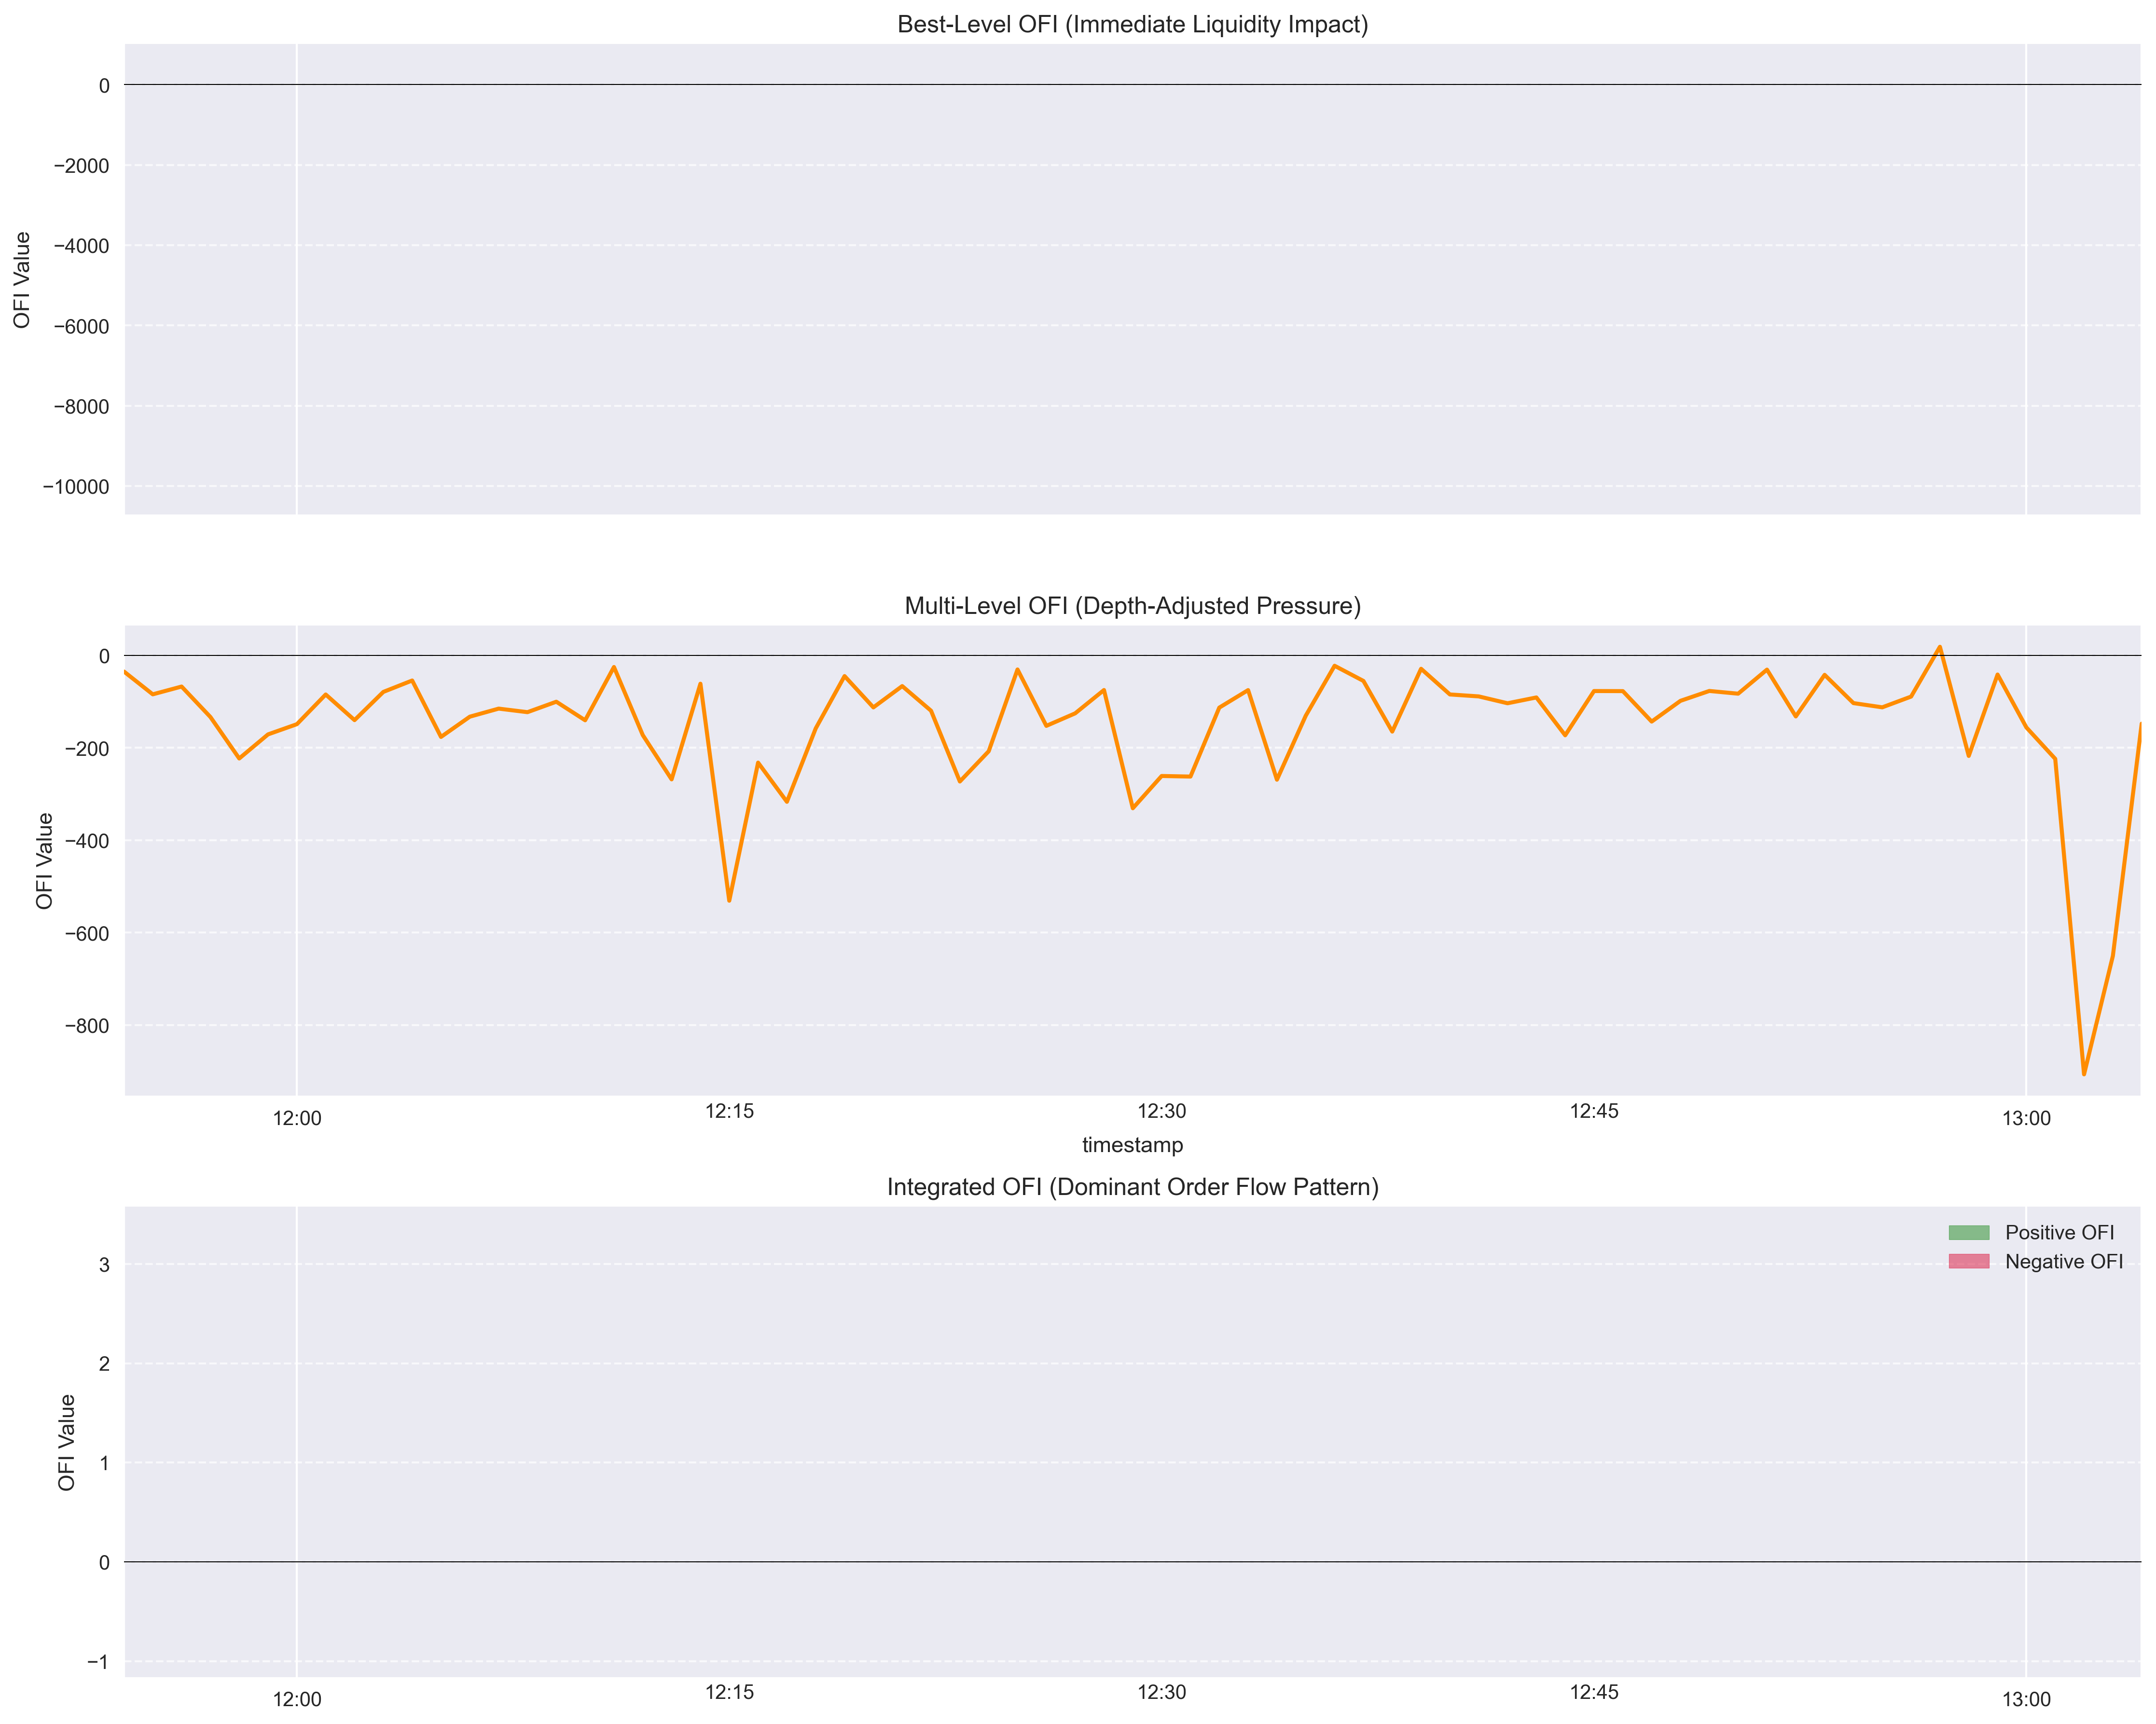

In [ ]:
from IPython.display import Image, display
display(Image(filename="./Output Images/fixed_triple_panel_ofi.png"))

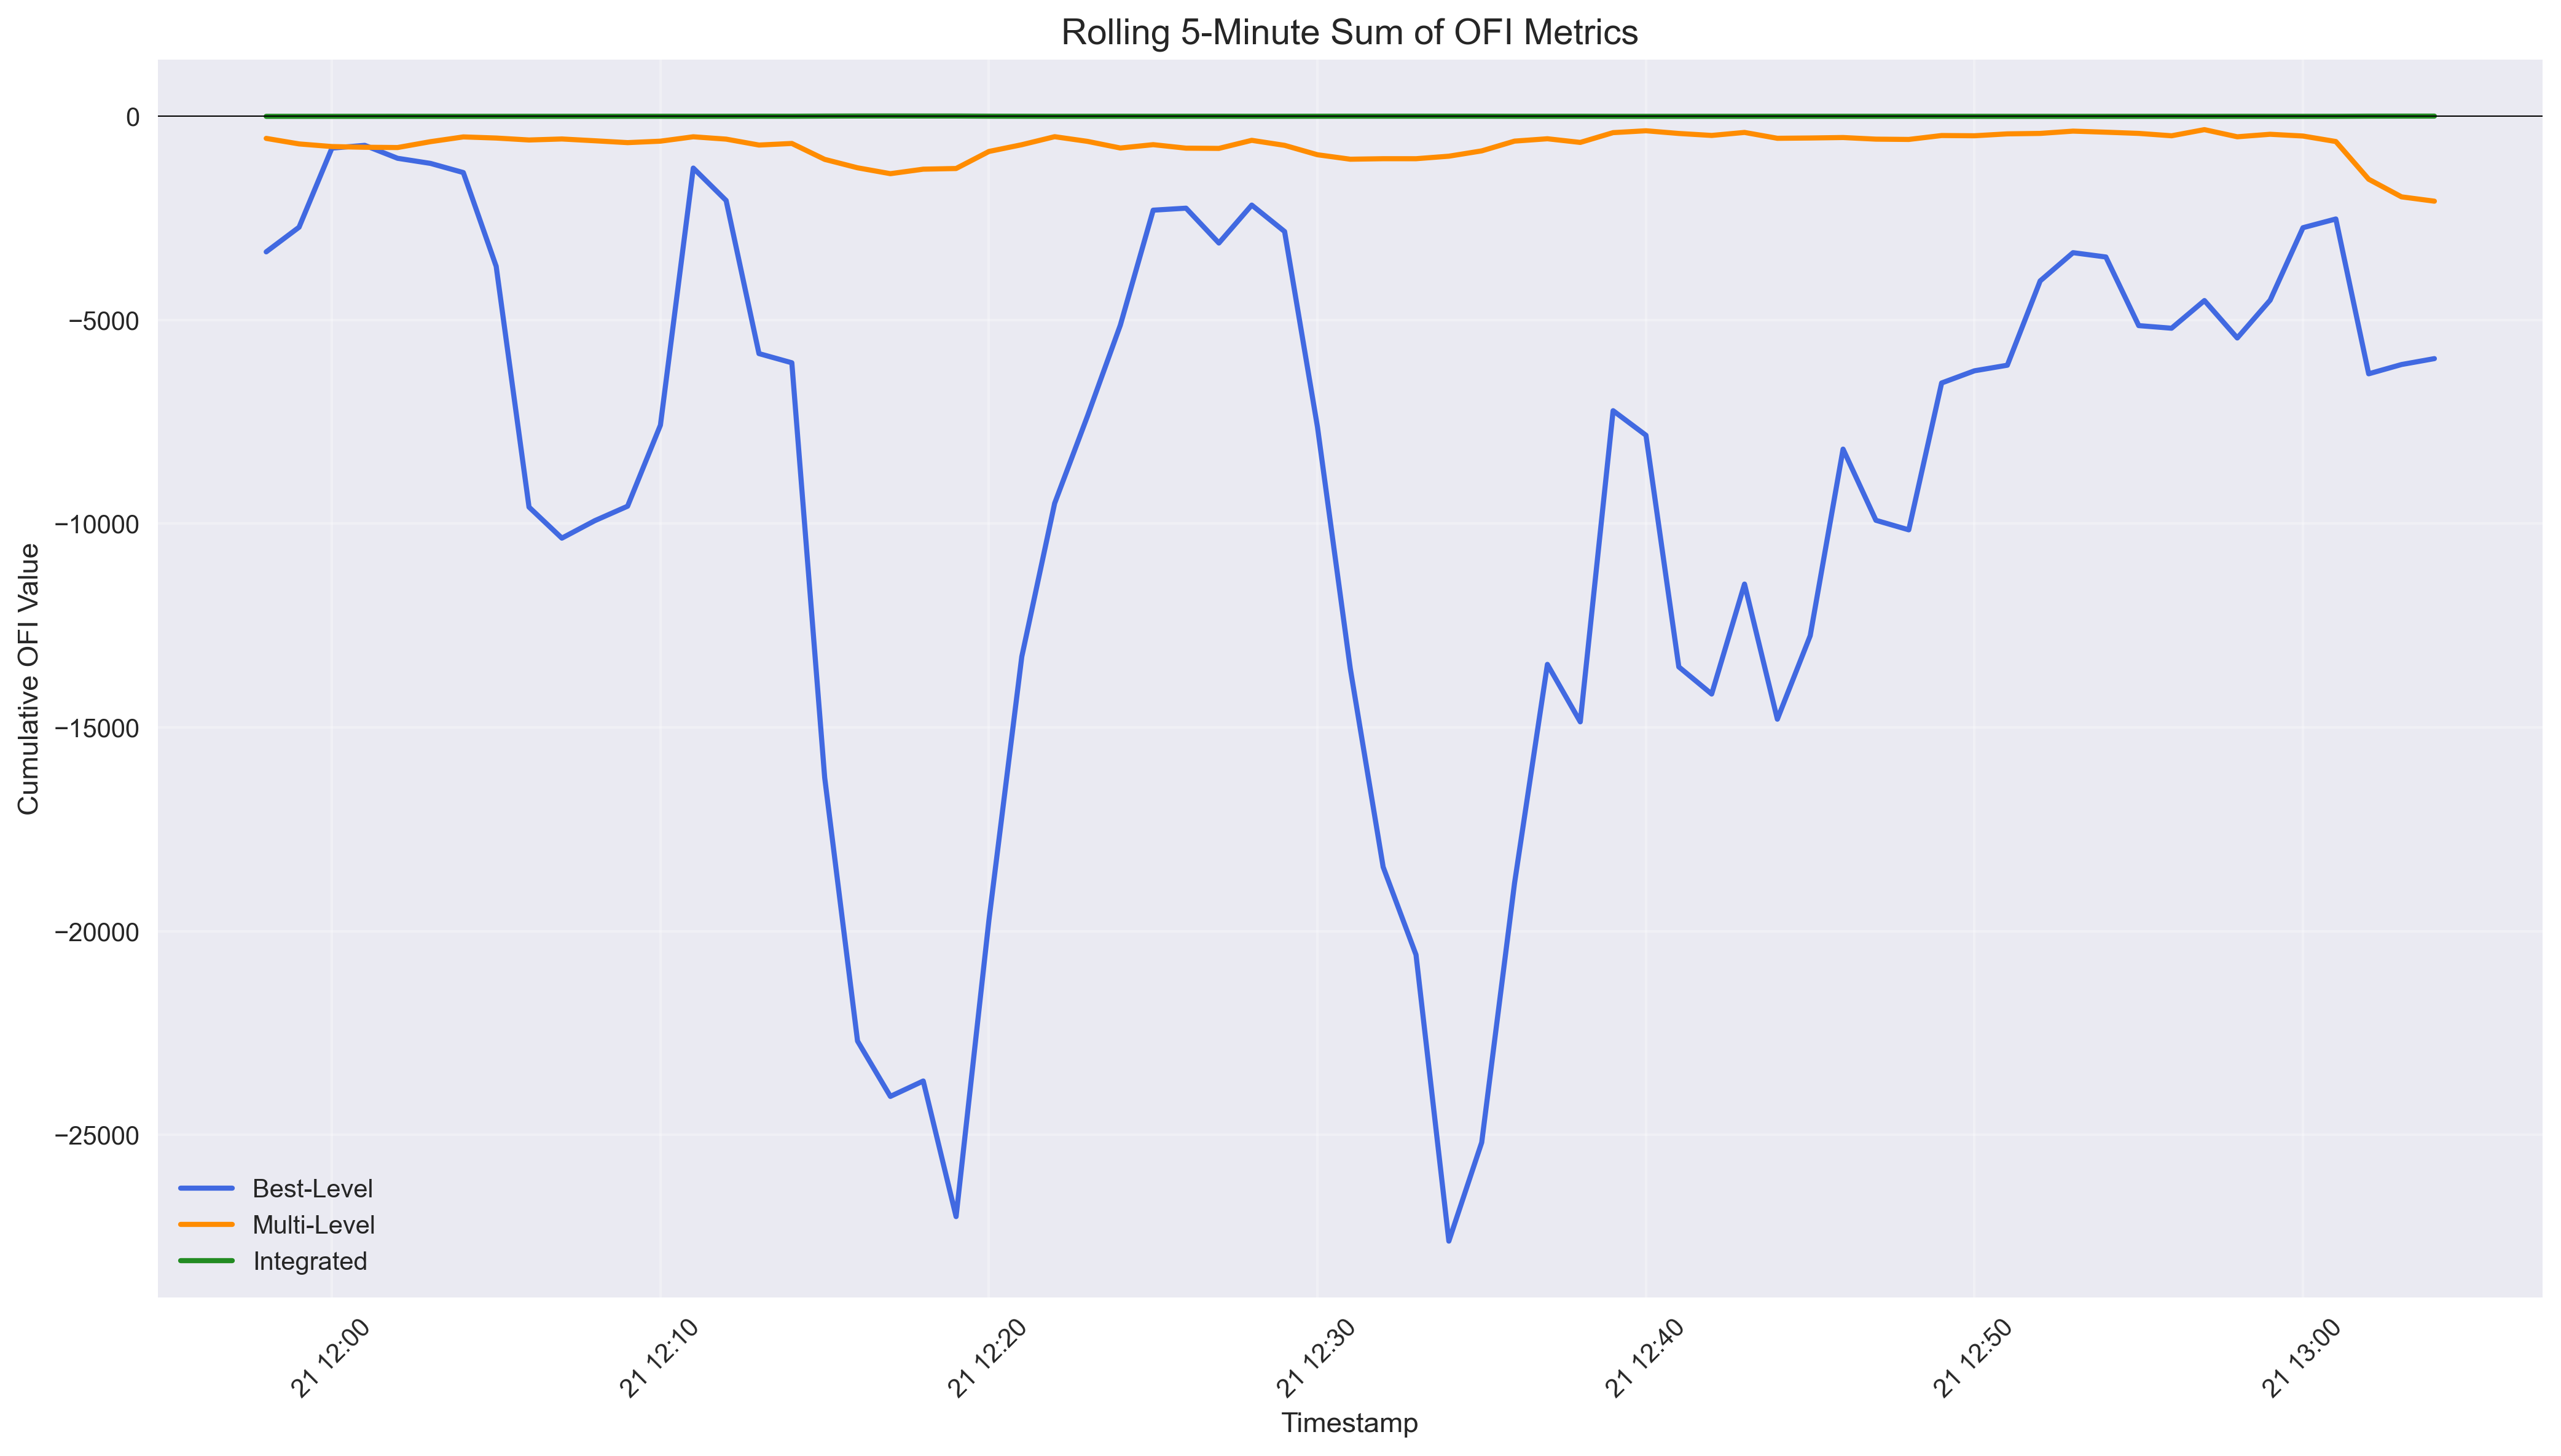

In [ ]:
display(Image(filename="./Output Images/rolling_ofi.png"))

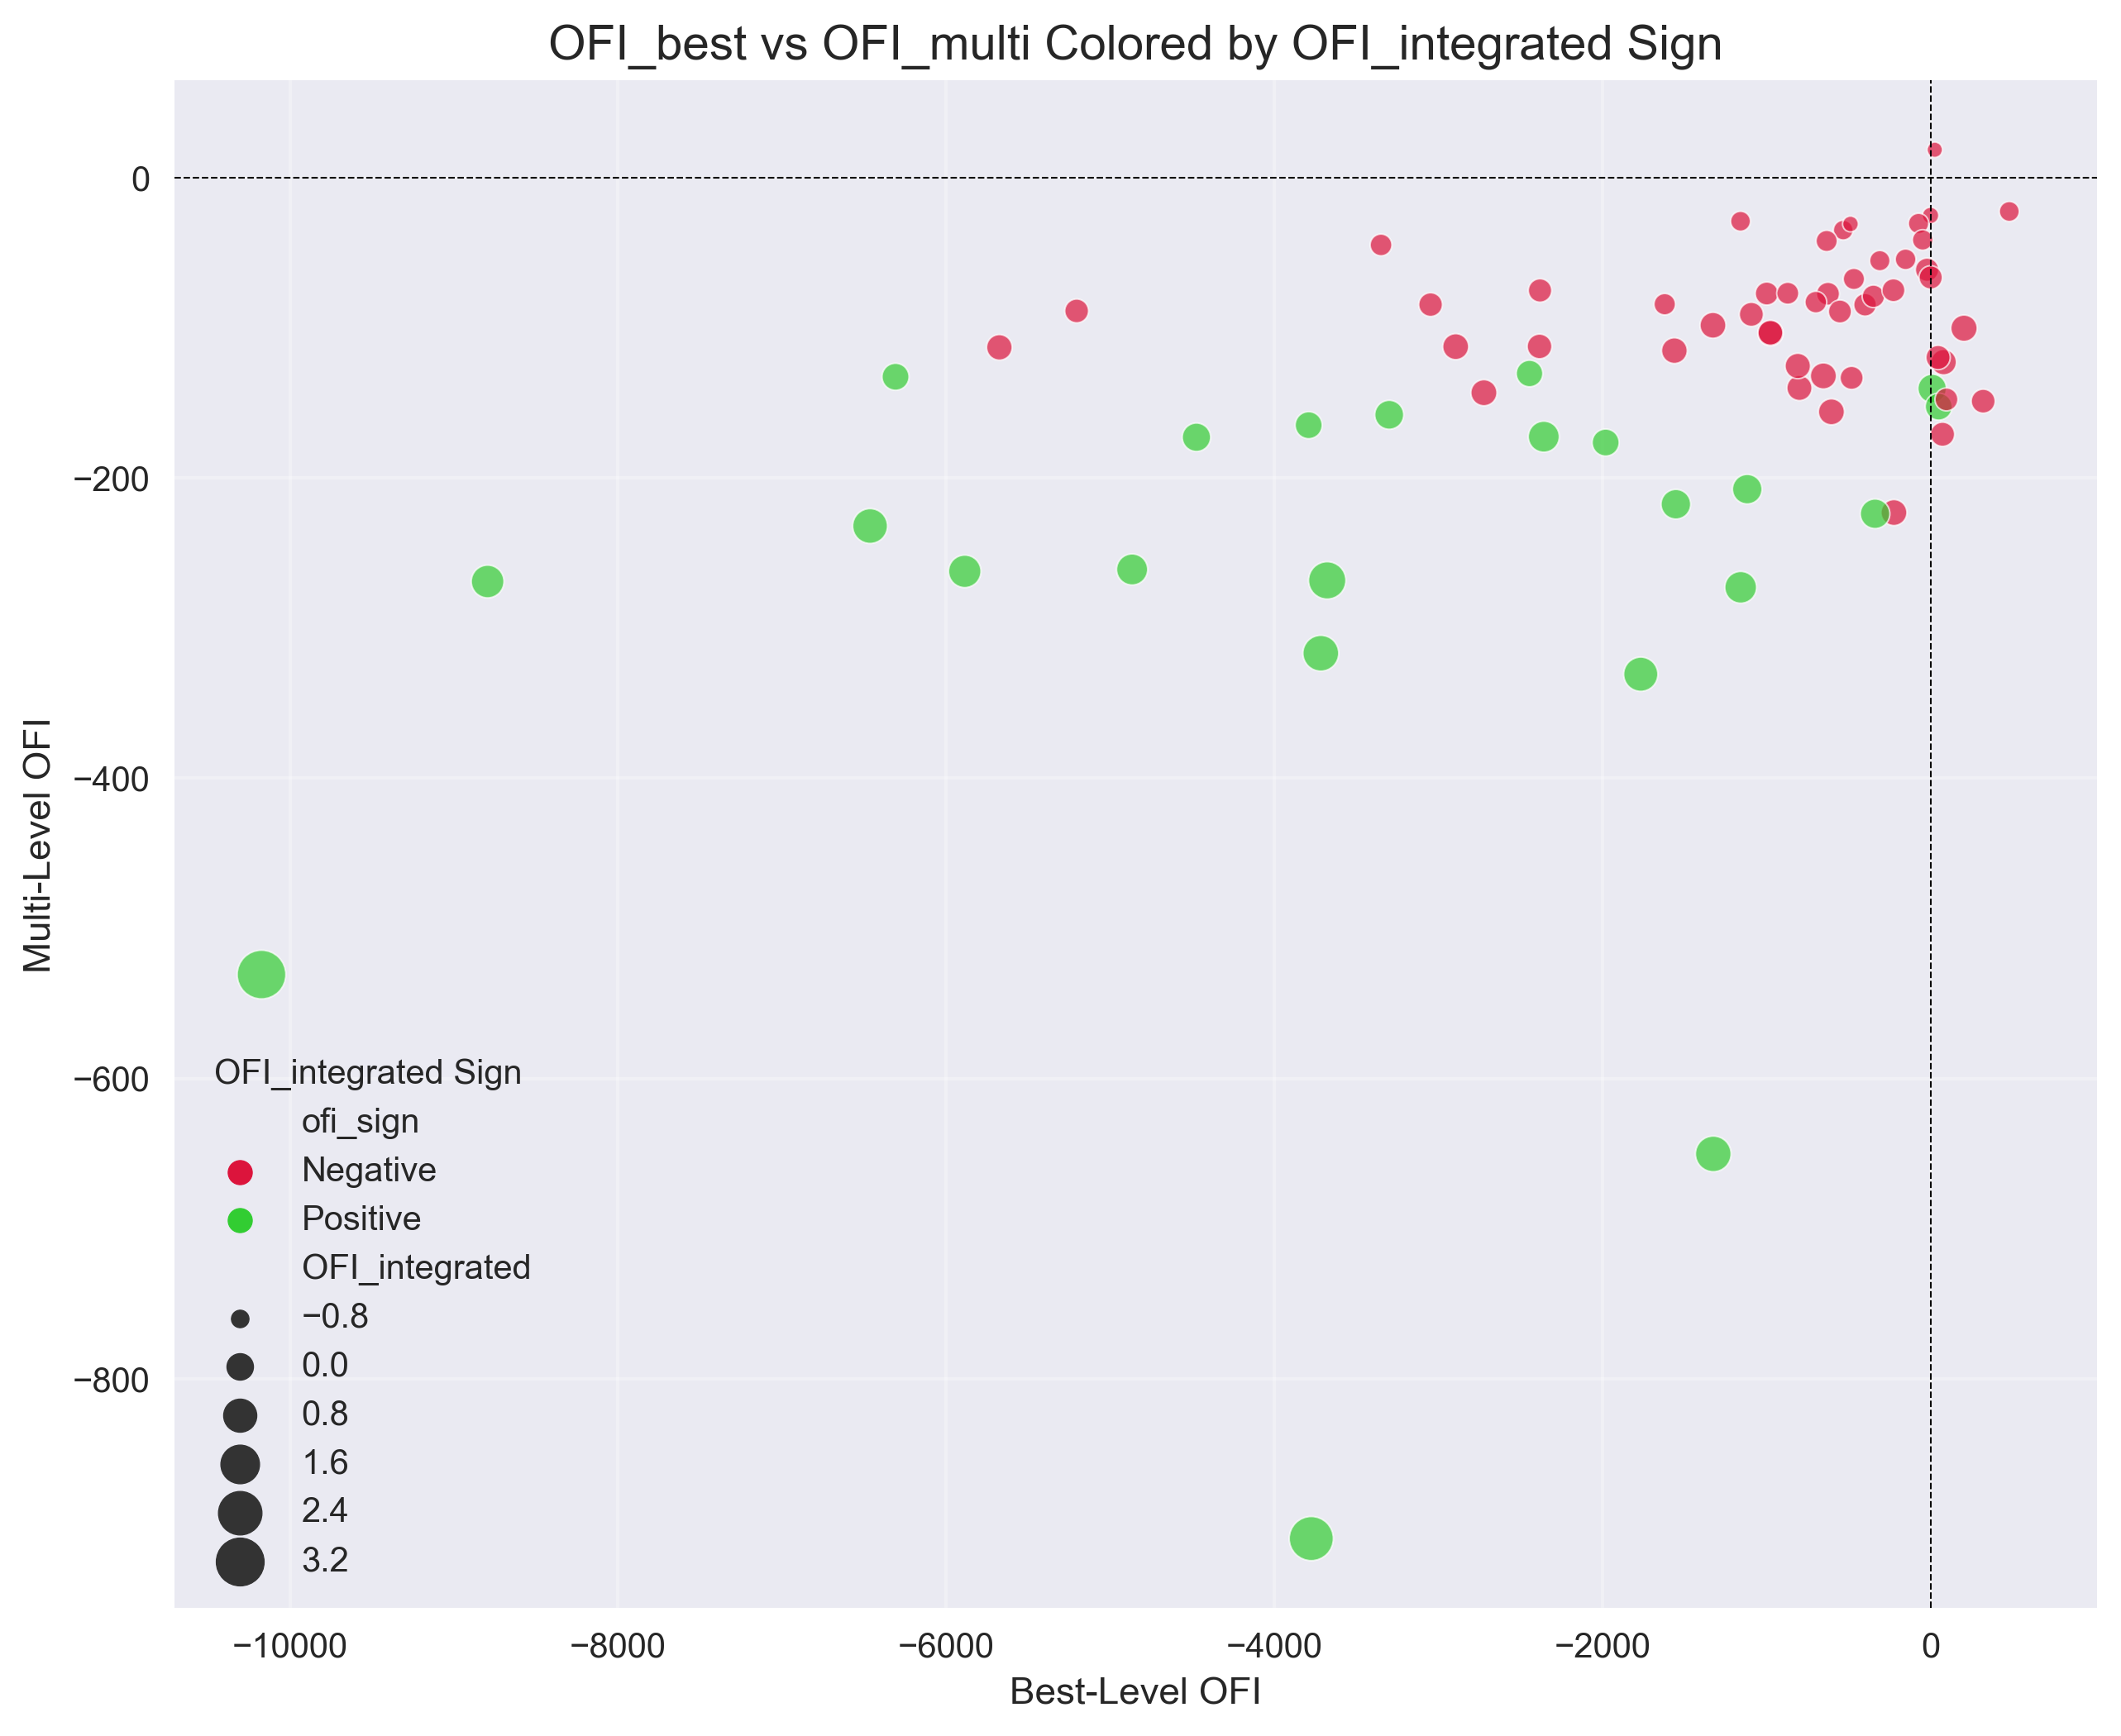

In [29]:
display(Image(filename="./Output Images/scatter_matrix_ofi.png"))